# Comparison of methods for numerical integration of given functions
From __A Guide to Monte Carlo Simulations in Statistical Physics__, Landau & Binder. Chapter 3.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import sympy as sy

In [2]:
plt.rcParams['figure.figsize'] = (9, 6)

## Intelligent methods

### - _Control variate method_

In this method, one selects a known, integrable function $f'(x)$ which has a relatively similar functional dependence on $x$ and only integrates the difference $[f'(x)-f(x)]$ by some Montecarlo method, i.e.

\begin{equation}\label{1}
    y_{est}=F'+\int_a^b\left[ f'(x)-f(x)\right]dx,
\end{equation}

where $F'=\int_a^b f'(x)dx$. The final estimate for $y_{est}$ can be improved without additional numerical effort by an intelligent choice of $f'(x)$.

### - _Importance sampling_

Instead of selecting all points with an equal probability, one can choose them accordinf to the anticipated importance of the value of the function at that point to the integral $p(x)$ and then weight the contribution by the inverse of the probability of choice. This is one of the simplest examples of the class of Monte Carlo methods known as _importance sampling_ which will be discussed later in greater detail. Using importance sampling an estimate for the integral is given by

\begin{equation}\label{2}
    y_{est}=\sum_i p^{-1}(x_i)f(x_i).
\end{equation}


For functions which vary widly over the interval of interest, this approach allow us to increase the sampling in the region in which the contribution to the integral is particularly large. Since the values of $x$ are no longer chosen with equal probability, we began to see the need for sequence. Obviously for oddly behaved functions some expertise is needed in choosing $p(x)$, but this can be done iteratively by first carrying out a rough Monte Carlo study and improving the choice of sampling convergence than the brute force method of simply generating many more points.

---------------------

#### Example 1: Estimating the value of $\pi$ using ___control variance method___

In the previous notebook we derived curve $f(x)$ from the parametric ecuation for the circle setting $r=1$ and the value of $\pi$ using the integral from $0$ to $1$.

\begin{align}\label{3}
    f(x) &=\sqrt{1-x^2}\\
    \pi &=4\int_0^1f(x)dx \label{4}
\end{align}

So, substituting \eqref{1} in \eqref{4}

\begin{align}\label{5}
    \pi_{est}=4(F'+\int_0^1\left[ f'(x;n)-f(x)\right]dx),
\end{align}

where $f'(x)$ is the Taylor series for the function $f(x)$ at $x=1$.


\begin{equation}\label{6}
    f'(x; n)=\sum_{k=0}^n\frac{f^{(k)}(1)}{k!}(x-1)^k
\end{equation}

- #### Calculate $f'(x;n)$, the Taylor expansion over $f(x)$ at $x=1$, and the integral $F'=F'(n)=\int_0^1f'(x;n)dx$.

In [3]:
x = sy.symbols('x')
f = (1-x**2)**(1/2); g = []; h = []

f.series(x, 1, 3, dir='-')
for i in range(2,10):
    temp = f.series(x, 1, i, dir='-').removeO()
    g.append(sy.lambdify(x, temp))                   # Computes f'(x;n), the Taylor expansion over f(x) 
    h.append(sy.integrate(temp, (x,0,1)))            # Computes F'=\int_0^1 f'(x;n)dx

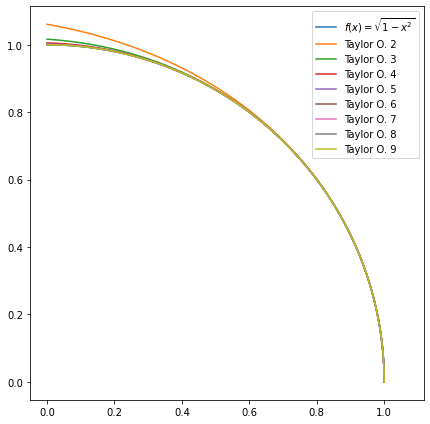

In [4]:
X = np.linspace(0, 1, 1000); f = lambda x: (1-x**2)**(1/2); labels = []

plt.plot(X, f(X), label = "$f(x)=\sqrt{1-x^2}$")
for i in range(8):
    labels.append("Taylor O. " + str(i+2))
    plt.plot(X, g[i](X), label = labels[-1])
plt.legend()

plt.tight_layout(); plt.axis('square')
plt.show()

- #### Integrate $\text{diff}(n) =\int_0^1\left[ f'(x;n)-f(x)\right]dx$ using the _random mapping_ method.

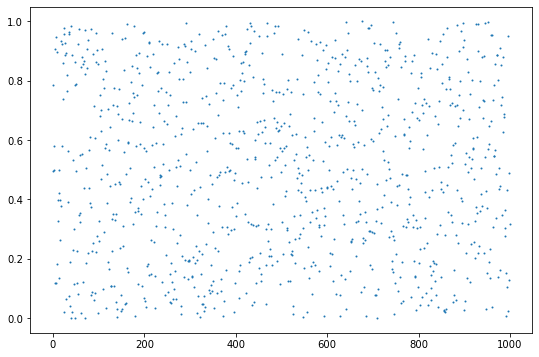

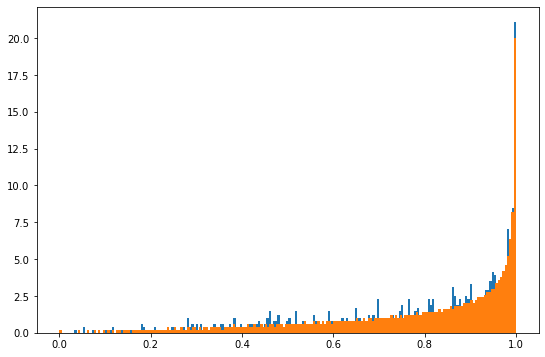

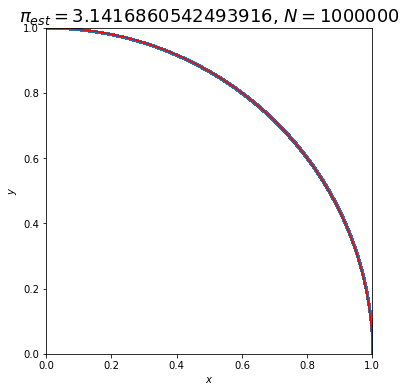

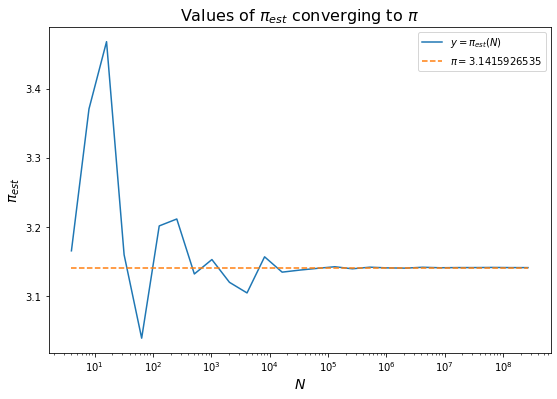

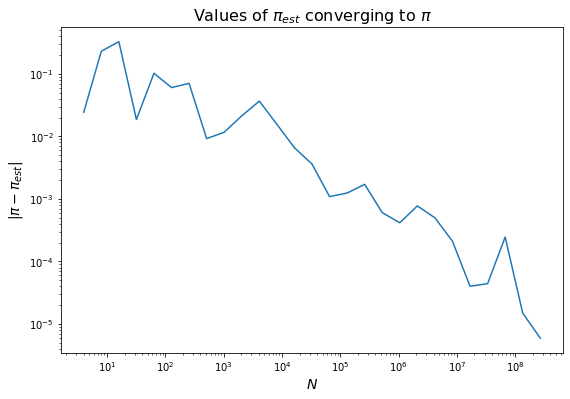

Functions imported


In [6]:
# Import the function "estimate_int" from the previous notebook
from ipynb.fs.full.Numerical_integration2 import estimate_int;
print("Functions imported")

In [7]:
diff = [];
for i in range(len(g)):
    diff_i = lambda x: f(x)-g[i](x)
    diff.append(estimate_int(100000, [0,1], diff_i)[2])   # output of the function: X_r, Y_r, int_est
    
diff              # integral estimate using random mapping

[-0.015974553191551284,
 -0.00336633996929299,
 -0.0009079476540587565,
 -0.00028301423022142596,
 -9.477466450191684e-05,
 -3.357272452383681e-05,
 -1.2512048386593895e-05,
 -4.7385501018601086e-06]

- #### Concatenate all previous functions to make a complete model

In [8]:
def control_variate_method(N, x_lims, expr, x_0=0, degree=3, dir="+-"):
    """
    N: points for random mapping method
    x_lims: [a,b] numerical values in x-axis
    expr: mathematical expression of the curve f(x). e.i. (1-x**2)**(1/2)
    x_0: the value toward which z tends. Can be any expression including oo and -oo.
    degree: Taylor n degree for the aprroximation of f(x)
    dir: The limit is bi-directional if dir="+-", from the right (z->z0+) if dir="+", and from the left (z->z0-) if dir="-". 
        For infinite z0 (oo or -oo), the dir argument is determined from the direction of the infinity (i.e., dir="-" for oo).
    """
    x = sy.symbols('x'); f = expr
    ff = sy.lambdify(x, f)

    temp = f.series(x, x_0, degree, dir=dir).removeO()
    g = sy.lambdify(x, temp)                   # Computes f'(x;n), the Taylor expansion over f(x) 
    h = sy.integrate(temp, (x,0,1))            # Computes F'=\int_0^1 f'(x;n)dx

    diff_func = lambda x: ff(x)-g(x)
    diff = (estimate_int(N, [0,1], diff_func)[2])   # output of the function: X_r, Y_r, int_est; using random mapping

    return h + diff, g

- #### Estimate $\pi$ for different $n$ Taylor approximations if $f(x)$ with $N=100,000$ points.

In [9]:
N = 10000; n= np.array([i for i in range(2,50,5)], dtype="int")
x_lims = [0,1]; f = lambda x: np.sqrt(1-x**2); expr = (1-x**2)**(1/2)

pi = []; taylor = []

for i in range(len(n)):    
    int_est, taylor_i = control_variate_method(N, x_lims, expr, x_0=0, degree=n[i], dir="-")
    pi.append(4*int_est)
    taylor.append(taylor_i)
pi = np.array(pi)

In [10]:
pd.DataFrame(data=np.array([n, pi]).T, columns=["$Degree-n$", "$\pi$"])

,$Degree-n$,$\pi$
0,2,3.13950428683717
1,7,3.13987718640286
2,12,3.14164109483167
3,17,3.14217480511776
4,22,3.14148656892994
5,27,3.14158039162197
6,32,3.14158885023384
7,37,3.14143176969711
8,42,3.14161918912844
9,47,3.14191436892573


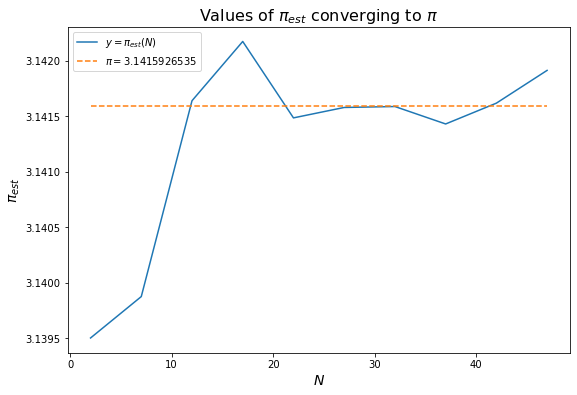

In [11]:
real_pi = 3.1415926535

plt.plot(n, pi, label=r"$y=\pi_{est}(N)$")
plt.plot(n, pi*0+real_pi, "--", label=r"$\pi=3.1415926535$")

# plt.axis('scaled'); 
plt.xlabel("$N$", fontsize=14); plt.ylabel("$\pi_{est}$", fontsize=14), 
plt.legend()
plt.title("Values of $\pi_{est}$ converging to $\pi$", fontsize=16)
plt.show()

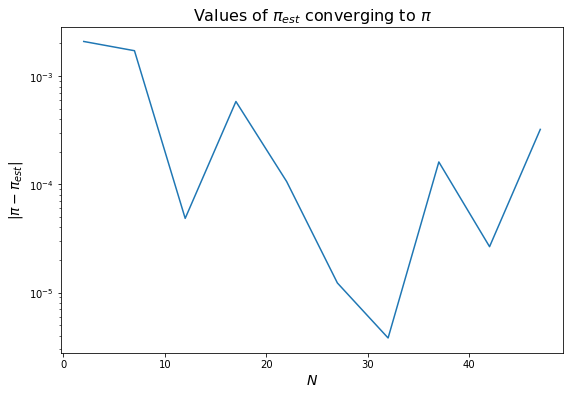

In [12]:
plt.plot(n, np.abs(pi-real_pi), label=r"$y=\pi_{est}(N)$");
plt.yscale("log")

# plt.axis('scaled'); 
plt.xlabel("$N$", fontsize=14); plt.ylabel("$|\pi-\pi_{est}|$", fontsize=14), 
plt.title("Values of $\pi_{est}$ converging to $\pi$", fontsize=16)
plt.show()